# Comparison with baseline configuration

Here, we load data from two configurations: the baseline (default) configuration and the best configuration found by our approach in the previous phases. The goal is to compare the two and see whether there is a singificant difference. 

## Load data

In [6]:
%matplotlib inline
%reload_ext autoreload
from rtxlib.rtx_run import setup_database, db
from factorial_anova_analysis import get_raw_data

index = "final-comparison-ttest-300_regular_cars-300_smart_cars" 

results = get_raw_data(index, False)

data retrieved from file final-comparison-ttest-300_regular_cars-300_smart_cars.pickle


## Display statistics

In [7]:
import pprint
from IPython.display import Markdown, display

def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
pp = pprint.PrettyPrinter(indent=4)

knobs = {}
data = {}
for r in results:
    knob_str = str(r[1])
    if not knob_str in knobs:        
        knobs[knob_str] = []
    if len(knobs[knob_str]) < 5000:
        knobs[knob_str].append(r[1])
    if not knob_str in data:        
        data[knob_str] = []
    if len(data[knob_str]) < 5000:
        data[knob_str].append(r[0])

printmd("**Found " + str(len(knobs)) + " different configurations in " + str(len(results)) + " data **", "green")

i = 1
for k in knobs:
    print "Configuration #" + str(i) + " (" + str(len(knobs[k])) + " data points):"
    i += 1
    pp.pprint(eval(k))
    print "\n"

<span style='color:green'>**Found 2 different configurations in 10000 data **</span>

Configuration #1 (5000 data points):
{   u'average_edge_duration_factor': 1.0,
    u'exploration_percentage': 0.0,
    u'freshness_cut_off_value': 700,
    u'freshness_update_factor': 5,
    u'max_speed_and_length_factor': 1.2218451599199196,
    u're_route_every_ticks': 10,
    u'route_random_sigma': 0.0}


Configuration #2 (5000 data points):
{   u'average_edge_duration_factor': 1.0,
    u'exploration_percentage': 0.0,
    u'freshness_cut_off_value': 700,
    u'freshness_update_factor': 5,
    u'max_speed_and_length_factor': 3,
    u're_route_every_ticks': 10,
    u'route_random_sigma': 0.0}




## Comparing best found configuration from approach to baseline (default configuration)

### Comparison #1: Performing t-test between the best configuration of the approach and the baseline (defau;t configuration)

The result shows that the best configuration of the approach is statistically significant better (a<0.05) than the baseline (default) configuration.

In [8]:
from analysis_lib.two_sample_tests import Ttest
from analysis_lib.two_sample_tests import TtestPower
from complaints_generator import generate_complaints
from scipy.stats import binom_test
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("savefig", dpi=150)
import random 
from IPython.display import Markdown, display

def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
random.seed(123456)

y_key = 'overhead'
alpha = 0.05
necessary_power = 0.80

fake_run_id = "123456"

knob_values = knobs.keys()
best_knob = knob_values[0]
other_knob_values = knob_values[1:] 

pvalues = {}
powers = {}

for i in knob_values:
    pvalues[i] = []
    powers[i] = []
        
step = 100

count = 0
sample_size = 5000

for other_knob_value in other_knob_values:   

    analysis_data = {}
    raw_data = data[best_knob] 
    analysis_data[0] = random.sample(raw_data, sample_size)

    raw_data = data[other_knob_value] 
    analysis_data[1] = random.sample(raw_data, sample_size)

    t = Ttest(fake_run_id, y_key, alpha).start(analysis_data, {})
    pvalues[other_knob_value].append(t["pvalue"])
    one_sided_p_value = t["pvalue"]/2

    if t["statistic"] < 0:
        t_p = TtestPower(fake_run_id, y_key, t["effect_size"], alpha, 'smaller').start(analysis_data, {})            
    else: 
        t_p = TtestPower(fake_run_id, y_key, t["effect_size"], alpha, 'larger').start(analysis_data, {})            
    powers[other_knob_value].append(t_p["power"])

    if one_sided_p_value < alpha and t_p["power"] >= necessary_power:
        printmd("**SIGNIFICANT DIFFERENCE**", "green")
        different = "smaller" if t["statistic"] < 0 else "larger"
        print "sample size: " + str(sample_size) 
        print "================"
        print "Overhead in " 
        pp.pprint(eval(best_knob))
        print " is " + different + " than in "
        pp.pprint(eval(other_knob_value))
        print "================"
        print "mean difference: " + str(t["mean_diff"]) 
        print "p value: " + str(one_sided_p_value)                                 
        print "effect size (Cohen's d): " + str(t["effect_size"]) 
        print "statistical power: " + str(t_p["power"])
        print "\n"

        count += 1
        if t["statistic"] >= 0:
            best_knob = other_knob_value
        break

    if sample_size == 5000:
        printmd("**NO SIGNIFICANT DIFFERENCE**", "red")
        different = "smaller" if t["statistic"] < 0 else "larger"
        print "sample size: " + str(sample_size) 
        print "================"
        print "Overhead in " 
        pp.pprint(eval(best_knob))
        print " is " + different + " than in "
        pp.pprint(eval(other_knob_value))
        print "================"
        print "mean difference: " + str(t["mean_diff"]) 
        print "p value: " + str(one_sided_p_value)                                 
        print "effect size (Cohen's d): " + str(t["effect_size"]) 
        print "statistical power: " + str(t_p["power"])
        print "\n"
    break

with log transformation...
with log transformation...


<span style='color:green'>**SIGNIFICANT DIFFERENCE**</span>

sample size: 5000
Overhead in 
{   u'average_edge_duration_factor': 1.0,
    u'exploration_percentage': 0.0,
    u'freshness_cut_off_value': 700,
    u'freshness_update_factor': 5,
    u'max_speed_and_length_factor': 1.2218451599199196,
    u're_route_every_ticks': 10,
    u'route_random_sigma': 0.0}
 is smaller than in 
{   u'average_edge_duration_factor': 1.0,
    u'exploration_percentage': 0.0,
    u'freshness_cut_off_value': 700,
    u'freshness_update_factor': 5,
    u'max_speed_and_length_factor': 3,
    u're_route_every_ticks': 10,
    u'route_random_sigma': 0.0}
mean difference: -0.0243584856917
p value: 4.80976249783e-05
effect size (Cohen's d): -0.0780393413632
statistical power: 0.987991250065




### Comparison #3: Visual comparison of best configuration of approach and baseline (default) configuration in box plots 

Even by visual inspection we can see an improvement in the case of our approach (so-far best configuration yields smaller overheads).

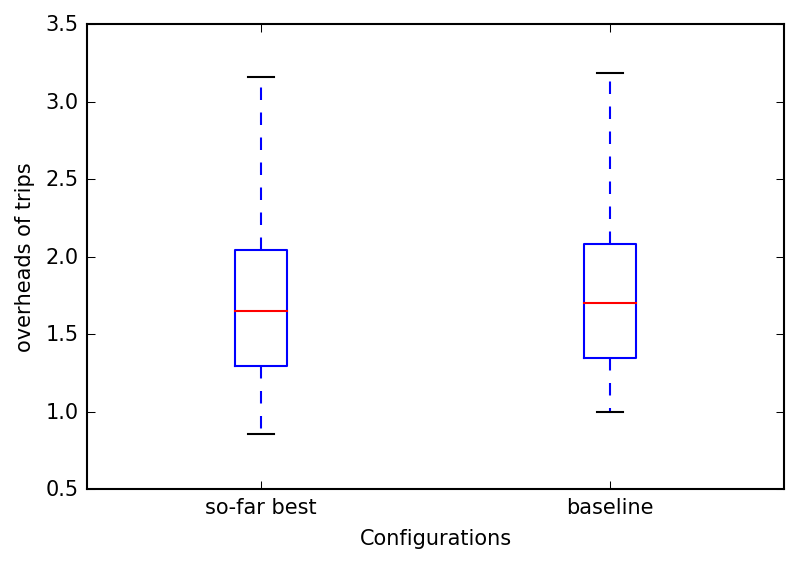

In [9]:
all_data = []

for knob in data.keys(): 
    analysis_data = [r[y_key] for r in data[knob]]
    all_data.append(analysis_data)
    
knob_labels = ["so-far best", "baseline"]
arithmetic_labels = [0,1]
fig,ax = plt.subplots()
ax.boxplot(all_data, 0, '', positions=arithmetic_labels)
plt.xticks(arithmetic_labels, knob_labels)
plt.legend(loc='best')
plt.ylabel('overheads of trips')
plt.xlabel('Configurations')
plt.show()